# GAN PARA FASHION MNIST

En este ejemplo vamos a tratar de generar imágenes similares a las del dataset de ropa FashionMNIST.

Pero esta vez lo váis a hacer vosotros :)

In [1]:
# importamos las librerías necesarias
import numpy as np
# buscad el dataset Fashion MNIST disponible en Keras e importadlo
# https://keras.io/datasets/
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import matplotlib.pyplot as plt

## DISCRIMINADOR

In [2]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()                 # modelo secuencial
    model.add(Conv2D(128,                # nº de filtros de la capa conv
              (3,3),                     # tamaño del kernel
              strides=(2, 2),            # el paso
              padding='same',            # el paddin
              input_shape=in_shape))     # la forma del tensor de entrada

    model.add(LeakyReLU(alpha=0.2))                                # función de activación
    model.add(Dropout(0.4))                                        # dropout del 0.4
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))  # capa conv 2
    model.add(LeakyReLU(alpha=0.2))                                # función de activación 2
    model.add(Dropout(0.4))                                        # dropout 2
    model.add(Flatten())                                           # se pasa a vector 1d
    model.add(Dense(1, activation='sigmoid'))                      # output de real o fake

    # compilar el modelo
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)             # optimizador adam
    model.compile(loss= 'binary_crossentropy',                     # por que el output es 0 o 1
                  optimizer= optimizer,
                  metrics= ['accuracy'])                           # accuracy como métrica

    return model

## GENERADOR

In [3]:
# definimos el generador
def define_generator(latent_dim):

    model = Sequential()                                                         # modelo secuencial
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))                              # capa 1 del generador: densa
    model.add(LeakyReLU(alpha=0.2))                                              # función de activación 1
    model.add(Reshape((7, 7, 128)))                                              # se formatea a vector 2D
    # aumentamos a 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))        # capa 2: convolucional
    model.add(LeakyReLU(alpha=0.2))                                              # función de activación 2

    # las imágenes del FASHION MNIST  aumentamos a 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))        # capa 3: convolucional
    model.add(LeakyReLU(alpha=0.2))                                              # función de activación 3
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))            # capa convolucional final
    return model

## DEFINIENDO LA GAN

In [4]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):

    d_model.trainable = False   # El discriminador no es entrenable
    model = Sequential()        # modelo secuencial
    model.add(g_model)          # G(Z)
    model.add(d_model)          # D(Z)

    model.compile(loss= 'binary_crossentropy',
                  optimizer= Adam(learning_rate=0.0002, beta_1= 0.5))

    return model

## CARGAR Y GENERAR EJEMPLOS REALES

In [5]:
# definimos las funciones para cargar el MNIST
def load_real_samples():

    from tensorflow.keras.datasets.fashion_mnist import load_data

    (trainX, _), (_, _) = load_data()      # load mnist dataset
    X = np.expand_dims(trainX, axis=-1)    # expand to 3d, e.g. add channels dimension
    X = X.astype('float32')                # convert from unsigned ints to floats
    X = X / 255.0                          # scale from [0,255] to [0,1]
    return X

# nos creamos una función que nos devuelva n_samples del dataset con sus
# etiquetas (1)
def generate_real_samples(dataset, n_samples):

    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(low= 0,
                           high= dataset.shape[0],
                           size= n_samples)

    X = dataset[ix]                     # las cogemos
    y = np.ones(shape= (n_samples, 1))  # Una columna de unos del tamaño de n samples

    return X, y

## GENERAR EJEMPLOS FALSOS

In [6]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    '''
    generar ruido; tantos elementos como batch size por dimensiones tenga el espacio latente
    Se crean números aleatorios de latent_dim x batch_size, y luego se hace el reshape para
    que tenga la forma deseada
    '''

    # generamos un vector de batch_size * latent_dim números aleatorios
    x_input = np.random.rand(latent_dim*batch_size)

    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    usamos la función anterior para generar los vectores latentes que
    necesitamos para generar muestras fake
    """
    x_input = generate_latent_points(latent_dim, n_samples)

    # introudicmos el ruido en el generador para que genere imagenes falsas
    X = g_model.predict(x_input)

    # etiqueta 0 por que son falsos y son para entrenar el discriminador
    y = np.zeros(shape= (n_samples, 1))   # vector columna de ceros

    return X, y

In [7]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

## DEFINIENDO EL ENTRENAMIENTO

In [8]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for epoch in range(n_epochs):                   # bucle para las epochs
        for batch in range(bat_per_epo):            # bucle para los batch

            X_real, y_real = generate_real_samples(dataset, half_batch)                             # preparamos los datos reales
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)     # preparamos los datos falsos (la mitad del batch size)

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))             # juntamos las imágenes/etiquetas reales con las falsas
            d_loss, _ = d_model.train_on_batch(X, y)                                    # actualizamos los pesos del discriminador

            """
            creamos etiquetas invertidas para el generador: utilizamos el D(x)
            para que piense que las muestras que le introducimos son reales, y
            en caso de que diga que no son reales, aprovechamos la información
            de sus gradientes para actualizar el G(z) para que la próxima vez
            los datos generados por G(z) sean más plausibles (parecidos a los
            reales)
            """
            X_GAN = generate_latent_points(latent_dim, n_batch)       # los puntos en el espacio latente, con el que se entrena el generador
            y_gan = np.ones(shape= (n_batch, 1))                      # etiquetas invertidas para el generador

            """
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            """
            g_loss = gan_model.train_on_batch(X_GAN, y_gan)

            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))   # mostramos el progreso

        # evaluate the model performance, EACH 10 EPOCHS
        if (epoch+1) % 10 == 0 or epoch == 0:
            X_real, y_real = generate_real_samples(dataset, n_batch)                      # preparamos ejemplos reales
            _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)                     # evaluamos el discriminador con datos reales
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)          # preparamos ejemplos fake
            _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)                     # evaluamos el discriminador con datos fake
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))  # mostramos cómo de bueno es nuestro policía
            save_plot(x_fake, epoch)                                                      # guardamos las imágenes generadas
            filename = 'generator_model_%03d.h5' % (epoch + 1)                            # guardamos el generador para tenerlo disponible más tarde
            g_model.save(filename)

## EJECUTANDO LA GAN CON EL FASHION MNIST DATASET

In [9]:

latent_dim = 100                           # size of the latent space
d_model = define_discriminator()           # create the discriminator
g_model = define_generator(latent_dim)     # create the generator
gan_model = define_gan(g_model, d_model)   # create the gan
dataset = load_real_samples()              # load image data FASHION MNIST

# train model
train(g_model,          # el generador
      d_model,          # el discriminador
      gan_model,        # la gan
      dataset,          # el dataset
      latent_dim)       # las dimensiones del espacio latente

Output hidden; open in https://colab.research.google.com to view.

In [10]:
ls

generated_plot_e001.png  generated_plot_e060.png  generator_model_010.h5  generator_model_070.h5
generated_plot_e010.png  generated_plot_e070.png  generator_model_020.h5  generator_model_080.h5
generated_plot_e020.png  generated_plot_e080.png  generator_model_030.h5  generator_model_090.h5
generated_plot_e030.png  generated_plot_e090.png  generator_model_040.h5  generator_model_100.h5
generated_plot_e040.png  generated_plot_e100.png  generator_model_050.h5  sample_data/
generated_plot_e050.png  generator_model_001.h5   generator_model_060.h5


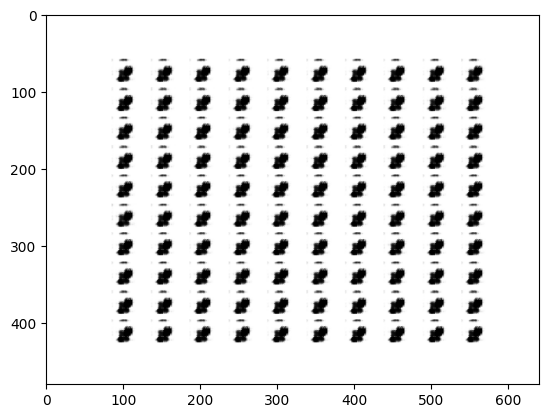

In [11]:
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

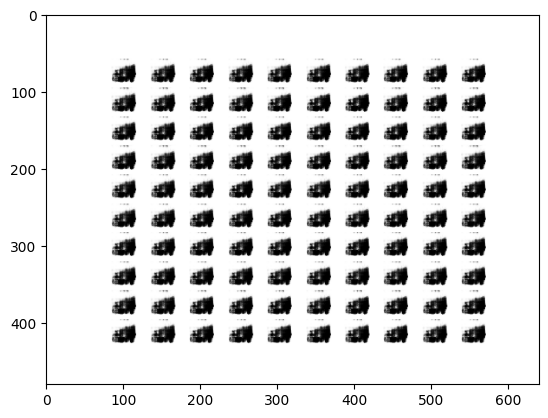

In [12]:
plt.imshow(plt.imread('generated_plot_e010.png'))
plt.show()

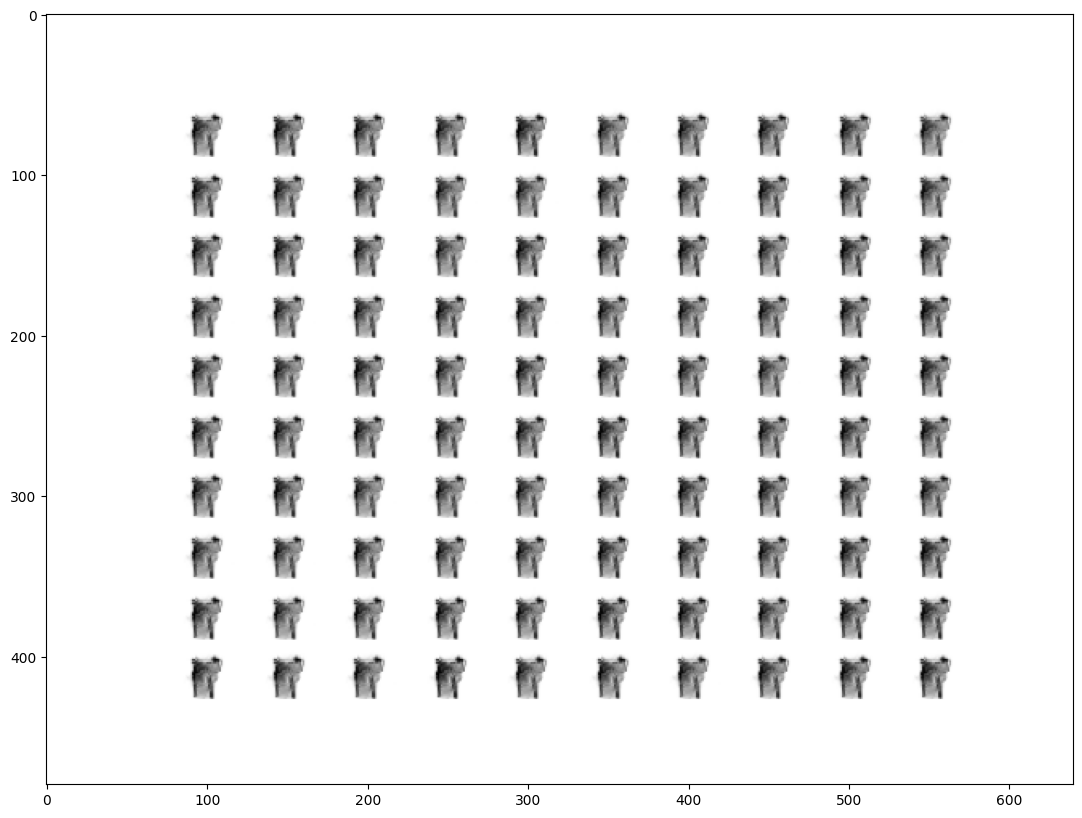

In [15]:
plt.figure(figsize= (14, 10))
plt.imshow(plt.imread('generated_plot_e100.png'))
plt.show()

Nada mal, ¿verdad? Pero... ¿y si quisiéramos generar solo zapatos? ¿O solo camisetas?

Para ello, necesitamos transformar esta GAN en una GAN condicional o CGAN.

Podéis guiaros con este ejemplo: https://keras.io/examples/generative/conditional_gan/.